In [10]:
import numpy as np
import pandas as pd
np.set_printoptions(threshold=10000,suppress=True)
import warnings
import matplotlib
import matplotlib.pyplot as plt
import copy
import sklearn.neural_network as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import seaborn as sns


# Pipeline de traitement

## Modèles

In [11]:
class PMC:
    def __init__(self, n_classes, n_features, learning_rate=0.01):
        self.n_classes = n_classes
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.early_stopper = 3
        self.converging = 0
        self.converging_threshold = 0.02
        self.weights = np.random.rand(n_classes, n_features)

    def fit(self, X, y):
        previous_weights = self.weights.copy()
        predictions = []
        for i in range(len(X)):
            prediction = self.predict(X[i])
            predictions.append(prediction)
            if prediction != y[i]:
                self.weights[prediction-1] -= self.learning_rate * X[i]
                self.weights[y[i]-1] += self.learning_rate * X[i]
        #compare weights to check if converged
        total_diff = 0.
        for i in range(len(self.weights)):
            total_diff += np.sum(np.abs(self.weights[i] - previous_weights[i]))
        if total_diff < self.converging_threshold:
            self.converging += 1
        else:
            self.converging = 0
        weights_equals = self.converging >= self.early_stopper
        return predictions, weights_equals
        
    def predict(self, X):
        scores = np.dot(self.weights, X)
        return np.argmax(scores)+1

    def score(self, X, y):
        correct = 0
        for i in range(len(X)):
            if self.predict(X[i]) == y[i]:
                correct += 1
        return correct / len(X)

In [15]:
def pmc_train(model, max_iters, X_train, y_train):
    converged = False
    iters = 0
    while not converged and iters < max_iters:
        predictions, weights_equals = model.fit(X_train, y_train)
        iters += 1
    return model, predictions

In [12]:
class Bagging:
    def __init__(self, k = 5):
        self.k = k
        self.models = [nn.MLPClassifier(hidden_layer_sizes=(3), learning_rate='adaptive', learning_rate_init = 0.01, max_iter=2000) for i in range(k)]
    
    def train(self, X, y):
        for i in range(self.k):
            self.models[i].fit(X[i], y[i])
            
    def predict(self, X):
        predictions = []
        for i in range(self.k):
            predictions.append(self.models[i].predict(X))
        
        return np.array(predictions).T

    def choose_prediction(self, X):
        predictions = self.predict(X)
        return np.array([np.argmax(np.bincount(predictions[i])) for i in range(len(predictions))])
    

## Pipeline

In [13]:
def LoadAndProcess(path, n_features, scaled = True):
    data = pd.read_csv(path, delim_whitespace=True)
    
    if scaled:
        scaler = StandardScaler()
        data.iloc[:, :n_features] = scaler.fit_transform(data.iloc[:, :n_features])
    
    x = data.iloc[:, :n_features].values
    y = data.iloc[:, n_features].values
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
    
    return X_train, X_test, y_train, y_test

def SplitAndSample(X, y, k):
    X_s, y_s = [], []
    for i in range(k):
        sample = resample(X, y, replace=False, n_samples=len(X)//2)
        X_s.append(sample[0])
        y_s.append(sample[1])

    X_s = np.array(X_s)
    y_s = np.array(y_s)
    return X_s, y_s

In [18]:
def performance(y_test, y_pred):
    print("Precision: ", precision_score(y_test, y_pred, average='macro'))
    print("Recall: ", recall_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

In [19]:
def Pipeline(path, n_classes, n_features):
    X_train, X_test, y_train, y_test = LoadAndProcess(path, n_features)
    Xtr_scaled, Xt_scaled, ytr_scaled, yt_scaled = LoadAndProcess(path, n_features, scaled=True)
    
    # ==== PMC ====
    
    pmc = PMC(n_classes, n_features)
    
    pmc, tr_preds = pmc_train(pmc, 5000, X_train, y_train)
    t_preds = [pmc.predict(x) for x in X_test]
    
    pmc, tr_s_preds = pmc_train(pmc, 5000, Xtr_scaled, ytr_scaled)
    t_s_preds = [pmc.predict(x) for x in Xt_scaled]
    
    print("================= PMC =================")
    performance(y_test, t_preds)
    performance(yt_scaled, t_s_preds)
    
    
    # ==== MLP ====
    mlp = nn.MLPClassifier(
    hidden_layer_sizes=(3), activation='relu', solver='adam',
    learning_rate='adaptive', learning_rate_init=0.01, max_iter=2000)

    mlp.fit(X_train, y_train)
    
    tr_preds = mlp.predict(X_train)
    t_preds = mlp.predict(X_test)
    
    tr_s_preds = mlp.predict(Xtr_scaled)
    t_s_preds = mlp.predict(Xt_scaled)
    
    print("================== MLP =================")
    performance(y_test, t_preds)
    performance(yt_scaled, t_s_preds)
    
    # ==== Bagging ====
    X_s, y_s = SplitAndSample(X_train, y_train, 3)
    X_s_scaled, y_s_scaled = SplitAndSample(Xtr_scaled, ytr_scaled, 3)
    
    bagging = Bagging(3)
    bagging.train(X_s, y_s)
    t_preds = bagging.choose_prediction(X_test)
    t_s_preds = bagging.choose_prediction(Xt_scaled)
    
    print("================= Bagging ==============")
    performance(y_test, t_preds)
    performance(yt_scaled, t_s_preds)
    

================= PMC =================
Precision:  0.8666666666666667
Recall:  0.7142857142857143
Accuracy:  0.76
Precision:  0.8581349206349206
Recall:  0.854775828460039
Accuracy:  0.84
================== MLP =================
Precision:  0.9824561403508771
Recall:  0.9761904761904763
Accuracy:  0.98
Precision:  0.9824561403508771
Recall:  0.9824561403508771
Accuracy:  0.98
================= Bagging ==============
Precision:  0.9824561403508771
Recall:  0.9761904761904763
Accuracy:  0.98
Precision:  0.9824561403508771
Recall:  0.9824561403508771
Accuracy:  0.98


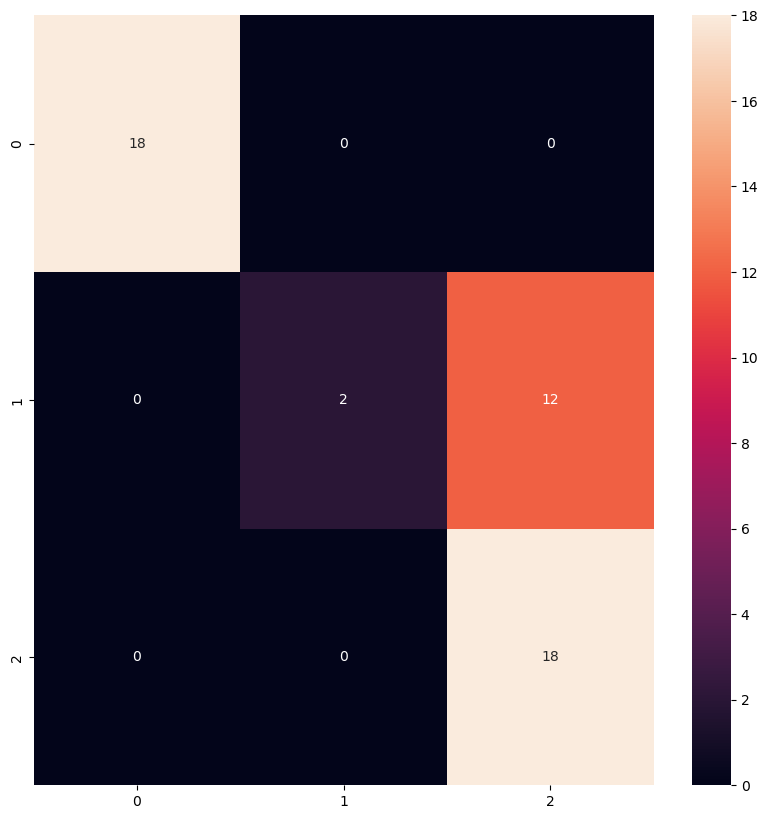

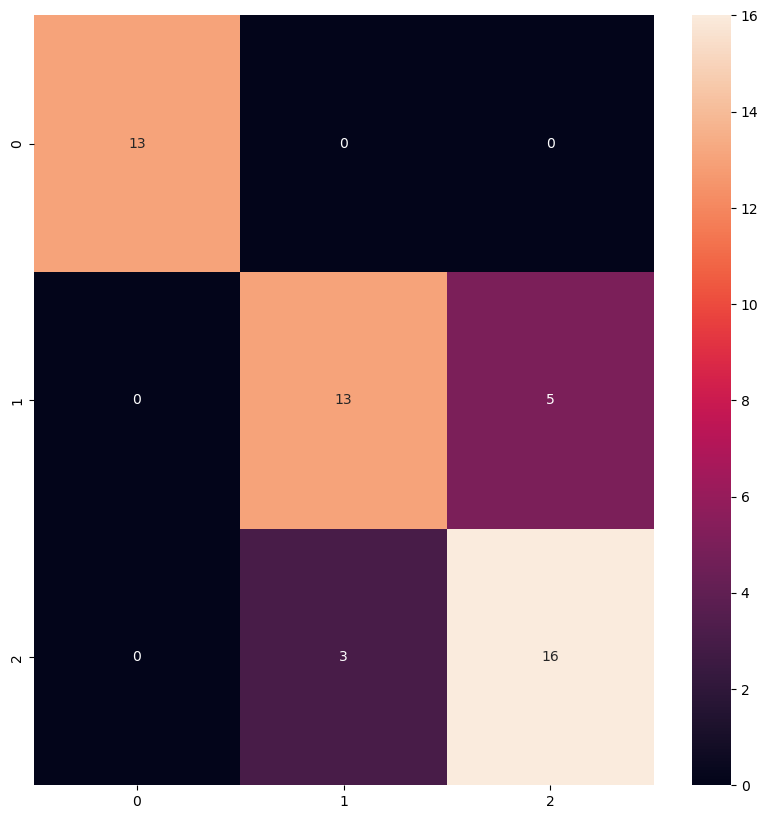

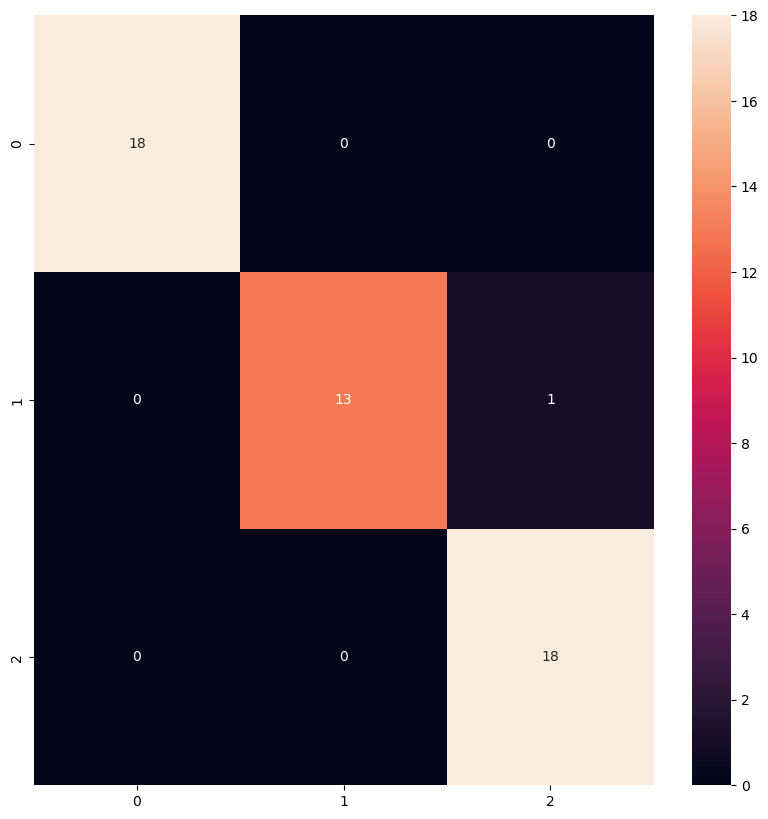

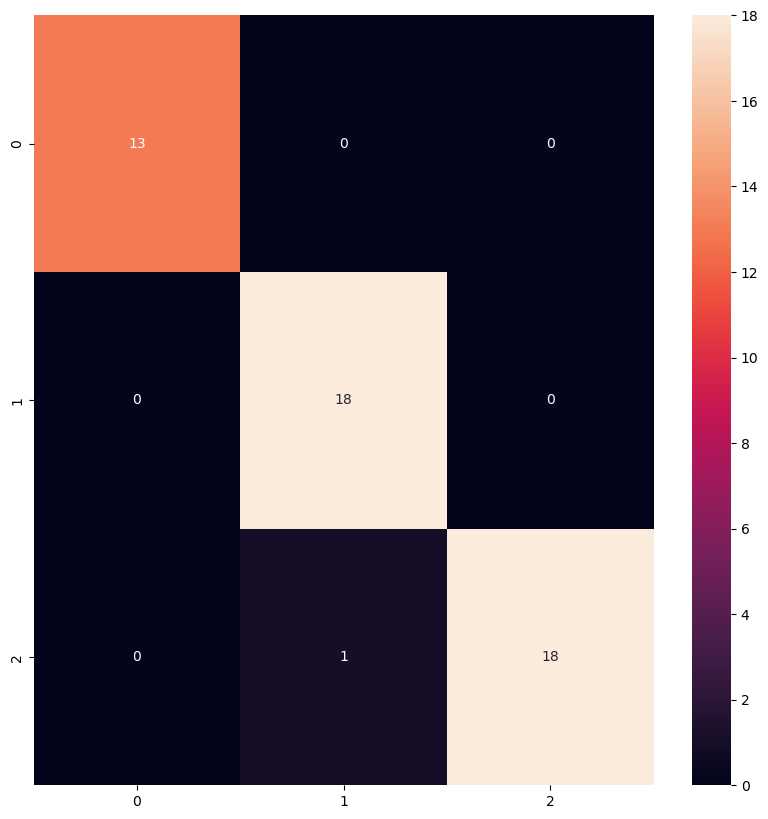

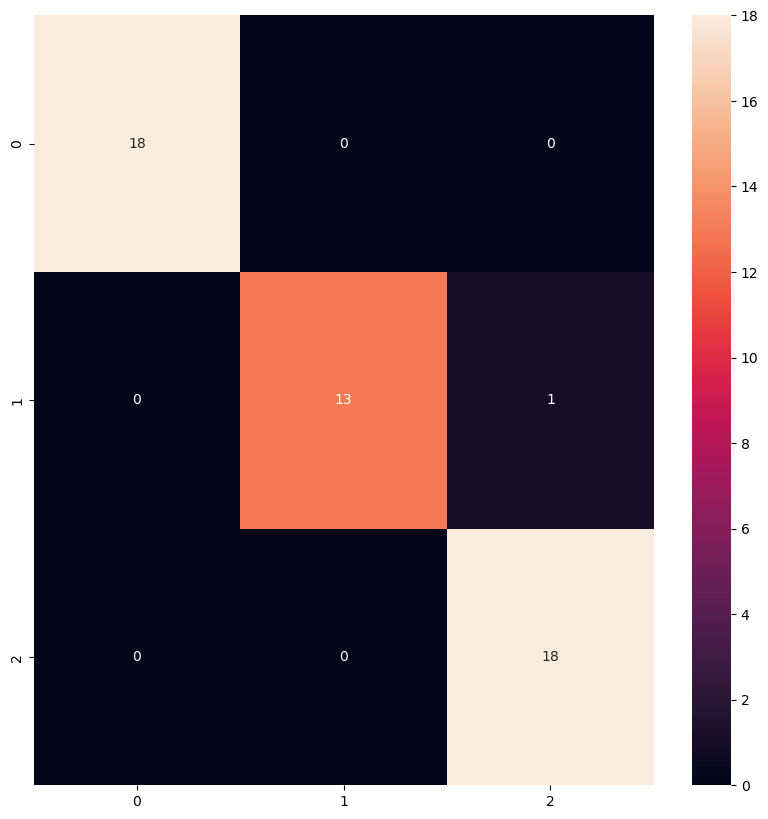

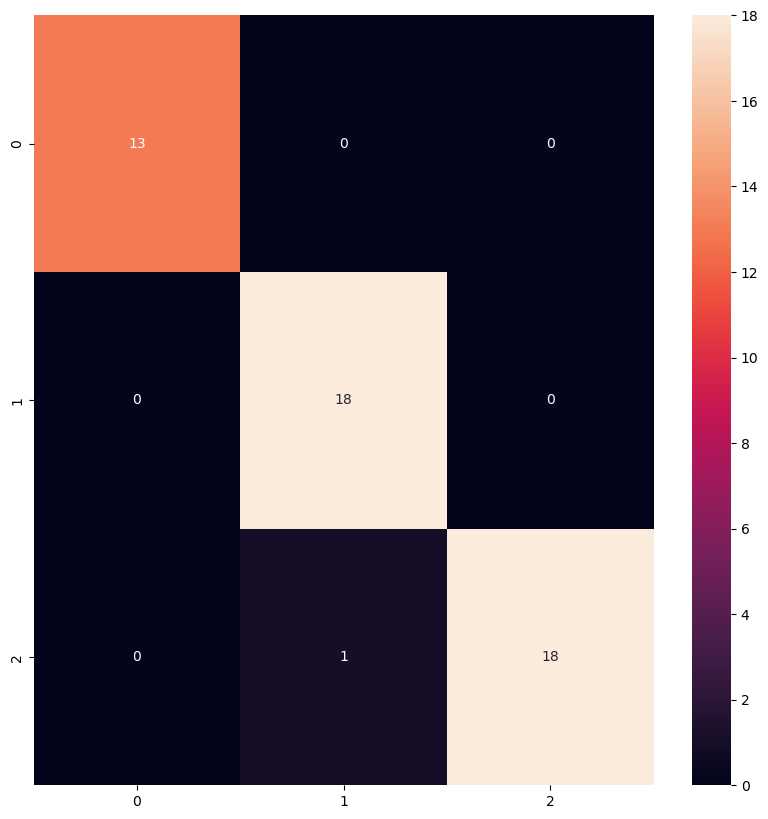

In [20]:
Pipeline("iris.txt", 3, 4)